## Load libraries

In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
InteractiveShell.ast_node_interactivity = 'last_expr'

In [9]:
import os,sys
import re

sys.dont_write_bytecode = True

In [10]:
import pandas as pd
# import geopandas as gpd
from sklearn.externals import joblib

import numpy as np
import matplotlib.pyplot as plt
import cv2

from pprint import pprint
from pathlib import Path

import pdb

In [17]:
this_nb_path = Path(os.getcwd())
ROOT = this_nb_path.parent.parent
SCRIPTS = ROOT/'scripts'
paths2add = [this_nb_path, SCRIPTS]

print("Project root: ", str(ROOT))
print("this nb path: ", str(this_nb_path))
print('Scripts folder: ', str(SCRIPTS))

for p in paths2add:
    if str(p) not in sys.path:
        sys.path.insert(0, str(p))
        print(str(p), "added to the path\n")
        
print(sys.path)

Project root:  /home/hayley/Playground/Spacenet_Preprocess
this nb path:  /home/hayley/Playground/Spacenet_Preprocess/notebooks/examples
Scripts folder:  /home/hayley/Playground/Spacenet_Preprocess/scripts
['/home/hayley/Playground/Spacenet_Preprocess/notebooks/scripts', '/home/hayley/Playground/Spacenet_Preprocess/notebooks', '/home/hayley/Playground/Spacenet_Preprocess/scripts', '/home/hayley/Playground/Spacenet_Preprocess/notebooks/examples', '/home/hayley/miniconda3/envs/fastai/lib/python36.zip', '/home/hayley/miniconda3/envs/fastai/lib/python3.6', '/home/hayley/miniconda3/envs/fastai/lib/python3.6/lib-dynload', '', '/home/hayley/miniconda3/envs/fastai/lib/python3.6/site-packages', '/home/hayley/miniconda3/envs/fastai/lib/python3.6/site-packages/IPython/extensions', '/home/hayley/.ipython']


In [12]:
# Load custom helper libraries
import output_helpers as oh
import convert_helpers as ch
import viz_helpers as vh


## Link fastai library

In [13]:
FASTAI_ROOT = '/home/hayley/Workspace/fastai/old/fastai'
FASTAI_SYMLINK = os.path.join(this_nb_path, 'fastai')
!echo {FASTAI_ROOT}, {FASTAI_SYMLINK}

/home/hayley/Workspace/fastai/old/fastai, /home/hayley/Playground/Spacenet_Preprocess/notebooks/examples/fastai


In [14]:
# !ln -s {FASTAI_ROOT} {FASTAI_SYMLINK}
# !rm {FASTAI_SYMLINK}
!ls -al . | grep fastai

## Import fastai libraries

In [15]:
from fastai.dataloader import *
from fastai.dataset import *

/home/hayley/miniconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/hayley/miniconda3/envs/fastai/lib/python3.6/site-packages/scipy/_lib/_numpy_compat.py:10: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing.nosetester import import_nose
/home/hayley/miniconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/hayley/miniconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/morestats.py:12: DeprecationWarning: Importing from numpy.testing.decorators is deprecated, import from numpy.testing instead.
  from numpy.testing.decorators import setastest
/home/hayley/miniconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.

### Import PyTorch


In [16]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch.utils.data.dataset import Dataset

from torchvision import datasets, transforms
from torch.autograd import Variable

SyntaxError: invalid syntax (<ipython-input-16-c40f41c3520e>, line 6)

## Set data path

### Sample datasets


In [18]:
DATA = Path("/home/hayley/Data_Spacenet/")

# Sample dataset
sample_dir = Path("/home/hayley/Data_Spacenet/SpaceNet_Roads_Sample/")
sample_root_dirs = [sample_dir/ city for city in ["AOI_2_Vegas_Roads_Sample",  
                                                  "AOI_3_Paris_Roads_Sample", 
                                                  "AOI_4_Shanghai_Roads_Sample", 
                                                  "AOI_5_Khartoum_Roads_Sample"]
                   ]

# Original big rgb(16), rgb8bits, mask (uint)
sample_rgb_dirs = [root/"RGB-PanSharpen" for root in sample_root_dirs]
sample_rgb8_dirs = [root/"RGB-PanSharpen-8bits" for root in sample_root_dirs]
sample_mask_dirs = [root/"Mask" for root in sample_root_dirs]

# Cropped 100x100 tif image tiles
sample_rgb_tile_dirs = list(map(get_crop_dir, sample_rgb_dirs))
sample_rgb8_tile_dirs = list(map(get_crop_dir, sample_rgb8_dirs))
sample_mask_tile_dirs = list(map(get_crop_dir, sample_mask_dirs))
# for d in sample_mask_tile_dirs:
#     nprint(d, d.exists())

sample_road_vec_dirs = [root/"geojson/spacenetroads" for root in sample_root_dirs]
sample_buffer_vec_dirs = [root/"geojson/buffer" for root in sample_root_dirs]


NameError: name 'get_crop_dir' is not defined

### Training datasets


In [ ]:
vegas_root = Path("/home/hayley/Data_Spacenet/AOI_2_Vegas_Roads_Train/")
paris_root = Path("/home/hayley/Data_Spacenet/AOI_3_Paris_Roads_Train/")
shanghai_root = Path("/home/hayley/Data_Spacenet/AOI_4_Shanghai_Roads_Train/")
k_root = Path("/home/hayley/Data_Spacenet/AOI_5_Khartoum_Roads_Train/")

train_root_dirs = [vegas_root, paris_root, shanghai_root, k_root]

# Original big rasters: rgb(16), rgb8bits, mask (uint)
train_rgb_dirs = [root/"RGB-PanSharpen" for root in train_root_dirs]
train_rgb8_dirs = [root/"RGB-PanSharpen-8bits" for root in train_root_dirs]
train_mask_dirs = [root/"Mask" for root in train_root_dirs]

# Cropped 100x100 tif image tiles
train_rgb_tile_dirs = list(map(get_crop_dir, train_rgb_dirs))
train_rgb8_tile_dirs = list(map(get_crop_dir, train_rgb8_dirs))
train_mask_tile_dirs = list(map(get_crop_dir, train_mask_dirs))

# vector file dirs
train_road_vec_dirs = [root/"geojson/spacenetroads" for root in train_root_dirs]
train_buffer_vec_dirs = [root/"geojson/buffer" for root in train_root_dirs]


### Simple sample datasets

In [ ]:
RGB8_DIR = Path('/home/hayley/Data_Spacenet/SpaceNet_Roads_Sample/'
                'AOI_2_Vegas_Roads_Sample/RGB-PanSharpen-8bits/')
RGB16_DIR = Path('/home/hayley/Data_Spacenet/SpaceNet_Roads_Sample/'
                 'AOI_2_Vegas_Roads_Sample/RGB-PanSharpen/')
MASK_DIR = Path('/home/hayley/Data_Spacenet/SpaceNet_Roads_Sample/'
                'AOI_2_Vegas_Roads_Sample/Mask/')
CROP8_DIR = RGB8_DIR.parent/"RGB-PanSharpen-8bits-Crop"
CROP16_DIR = RGB16_DIR.parent/"RGB-PanSharpen-Crop"

In [ ]:
RGB8_FILES = [f for f in RGB8_DIR.iterdir() if f.suffix == '.tif']
RGB16_FILES = [f for f in RGB16_DIR.iterdir() if f.suffix == '.tif']

MASK_FILES = [f for f in MASK_DIR.iterdir() if f.suffix == '.tif']
print(len(RGB8_FILES), len(MASK_FILES))

In [ ]:
RGB8_CROP_DIR = RGB8_DIR.parent / 'RGB-PanSharpen-8bits-Crop'
RGB8_CROP_DIR.mkdir(exist_ok=True)

In [ ]:
# check if the simple image loading works
im = cv2.imread(str(RGB8_FILES[0]), -1)

In [ ]:
mask = cv2.imread(str(MASK_FILES[0]),-1)
nprint("im shape: ", im.shape)
nprint('mask shape: ', mask.shape)
plt.imshow(im)

In [ ]:
# Create train, dev, test indices

(-1, 1)

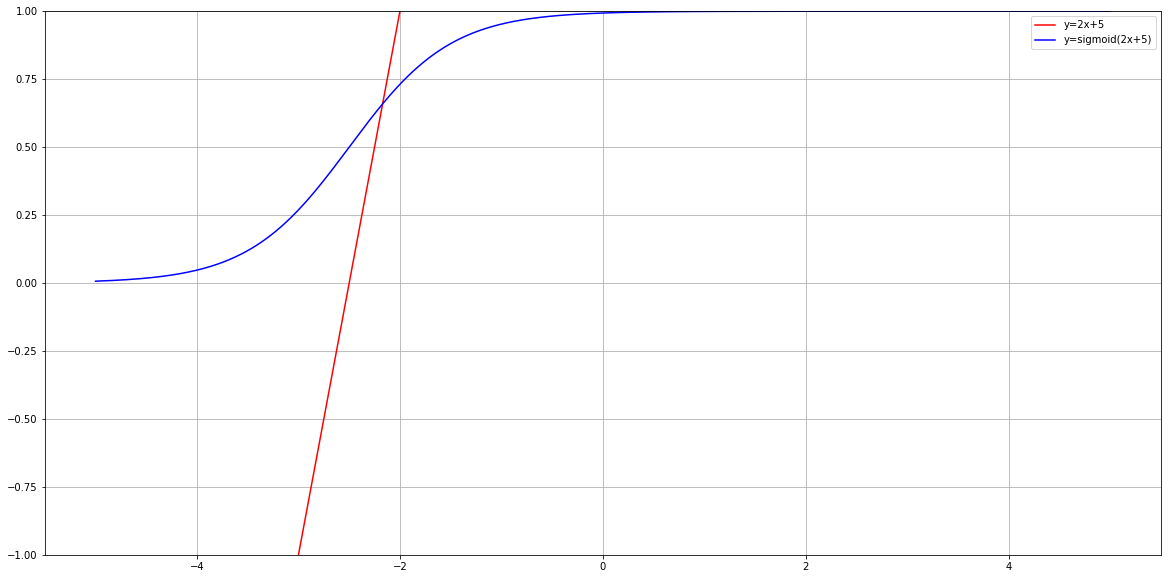

In [23]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)


x = np.linspace(-5,5,1000)
y1 = 2*x + 5

def sigmoid(x):
    return 1/(1+np.exp(-x))

y2 = sigmoid(y1)

f, ax = plt.subplots()
ax.plot(x,y1, color='r', label='y=2x+5')
ax.plot(x,y2, color='b', label='y=sigmoid(2x+5)')
ax.legend()
ax.grid(True)
ax.set_ylim(-1,1)